In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle # For custom splitting if needed

2025-06-28 11:20:38.205967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751109638.389404      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751109638.440922      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# --- Configuration ---
DATA_ROOT = '/kaggle/input/asvspoof-dataset-2019'
# Training paths
TRAIN_AUDIO_FOLDER = os.path.join(DATA_ROOT, 'LA', 'ASVspoof2019_LA_train', 'flac')
TRAIN_PROTOCOL_FILE = os.path.join(DATA_ROOT, 'LA', 'ASVspoof2019_LA_cm_protocols', 'ASVspoof2019.LA.cm.train.trn.txt')
# Development (DEV) paths for validation during training
DEV_AUDIO_FOLDER = os.path.join(DATA_ROOT, 'LA', 'ASVspoof2019_LA_dev', 'flac')
DEV_PROTOCOL_FILE = os.path.join(DATA_ROOT, 'LA', 'ASVspoof2019_LA_cm_protocols', 'ASVspoof2019.LA.cm.dev.trl.txt')
# Evaluation (EVAL) paths for final, unseen testing
EVAL_AUDIO_FOLDER = os.path.join(DATA_ROOT, 'LA', 'ASVspoof2019_LA_eval', 'flac')
EVAL_PROTOCOL_FILE = os.path.join(DATA_ROOT, 'LA', 'ASVspoof2019_LA_cm_protocols', 'ASVspoof2019.LA.cm.eval.trl.txt')

SAMPLE_RATE = 16000      # 16 kHz audio
CLIP_LENGTH = 5          # seconds per file (This will be the length *after* trimming and padding/truncating)
N_MELS = 128             # spectrogram feature size
NUM_TARGETS = 2          # classes: spoof or bonafide
BATCH_SIZE = 32          # Keep this, or try 16 if OOM persists
AUTOTUNE = tf.data.AUTOTUNE # For optimal performance with tf.data

In [3]:
# --- Determine the correct MAX_T based on CLIP_LENGTH ---
# Ensure consistent `n_fft` and `hop_length` for mel spectrogram calculation.
N_FFT = 400
HOP_LENGTH = 160
DUMMY_AUDIO_FOR_MAX_T = np.zeros(SAMPLE_RATE * CLIP_LENGTH, dtype=np.float32)
DUMMY_MEL_SPEC_FOR_MAX_T = librosa.feature.melspectrogram(
    y=DUMMY_AUDIO_FOR_MAX_T, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH)
MAX_T = DUMMY_MEL_SPEC_FOR_MAX_T.shape[1]
print(f"Calculated MAX_T for {CLIP_LENGTH}s clip (n_fft={N_FFT}, hop_length={HOP_LENGTH}): {MAX_T} time steps.")

Calculated MAX_T for 5s clip (n_fft=400, hop_length=160): 501 time steps.


In [4]:
# --- Load labels and file paths from protocol file ---
def load_protocol_data(protocol_file, audio_folder):
    filepaths = []
    labels = []
    file_to_label_map = {}

    try:
        with open(protocol_file, 'r') as proto:
            for row in proto:
                parts = row.strip().split()
                fid = parts[1]
                label = 1 if parts[-1] == 'bonafide' else 0
                file_to_label_map[fid] = label
    except FileNotFoundError:
        raise SystemExit(f"Protocol file missing: {protocol_file}")

    skipped_files_count = 0
    for fid, lbl in file_to_label_map.items():
        filepath = os.path.join(audio_folder, fid + '.flac')
        if os.path.exists(filepath):
            filepaths.append(filepath)
            labels.append(lbl)
        else:
            skipped_files_count += 1

    print(f"→ Loaded {len(filepaths)} valid file paths and labels from protocol '{os.path.basename(protocol_file)}'. Skipped {skipped_files_count} missing files.")
    return filepaths, labels

In [5]:
# --- Python function to be wrapped by tf.py_function ---
def _decode_flac_and_process(filepath_tensor, sample_rate_val, clip_length_val, n_mels_val, max_t_val, n_fft_val, hop_length_val):
    # Convert tensor to string
    filepath = filepath_tensor.numpy().decode('utf-8')

    # Convert all incoming TensorFlow Tensors to native Python types
    # This is crucial for librosa which expects native Python types for its parameters.
    sample_rate = sample_rate_val.numpy().item() # .item() extracts scalar from 0-d array
    clip_length = clip_length_val.numpy().item()
    n_mels = n_mels_val.numpy().item()
    max_t = max_t_val.numpy().item()
    n_fft = n_fft_val.numpy().item()
    hop_length = hop_length_val.numpy().item()

    # Load audio using librosa (Python operation)
    audio, _ = librosa.load(filepath, sr=sample_rate, mono=True) # Ensure mono

    # --- IMPORTANT: Silence Trimming with Librosa ---
    audio_trimmed, _ = librosa.effects.trim(audio, top_db=60)
    if audio_trimmed.shape[0] == 0:
        # Handle empty audio after trim: return a dummy silent array
        audio_trimmed = np.zeros(sample_rate * clip_length, dtype=np.float32)

    # Ensure uniform length
    target_audio_length = sample_rate * clip_length
    if len(audio_trimmed) > target_audio_length:
        audio_processed = audio_trimmed[:target_audio_length]
    else:
        padding_needed = target_audio_length - len(audio_trimmed)
        audio_processed = np.pad(audio_trimmed, (0, padding_needed), mode='constant')

    # Generate Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=audio_processed, sr=sample_rate, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length
    )
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Ensure spectrogram time dimension is consistent
    if mel_db.shape[1] < max_t:
        pad_amt = max_t - mel_db.shape[1]
        mel_db = np.pad(mel_db, ((0,0),(0,pad_amt)), mode='constant')
    elif mel_db.shape[1] > max_t:
        mel_db = mel_db[:, :max_t]

    # Add channel dimension
    return mel_db[..., np.newaxis].astype(np.float32) # Return as float32

In [6]:
# --- TensorFlow Data Processing Function using tf.py_function ---
@tf.function # Decorator to compile this function into a TensorFlow graph for performance
def preprocess_audio_and_generate_mel_spec(filepath, label):
    # Pass configuration variables as tensors to tf.py_function.
    features = tf.py_function(
        _decode_flac_and_process,
        inp=[filepath, SAMPLE_RATE, CLIP_LENGTH, N_MELS, MAX_T, N_FFT, HOP_LENGTH],
        Tout=tf.float32
    )
    # IMPORTANT: Set the shape after tf.py_function, as TensorFlow cannot infer it.
    features.set_shape([N_MELS, MAX_T, 1])

    # One-hot encode the label
    label_one_hot = tf.one_hot(label, depth=NUM_TARGETS)
    return features, label_one_hot

In [7]:
# --- Create tf.data.Dataset pipelines ---
def create_dataset(filepaths, labels, shuffle_buffer_size=None, batch_size=BATCH_SIZE, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))

    if is_training:
        if shuffle_buffer_size:
            dataset = dataset.shuffle(shuffle_buffer_size)
        else:
             dataset = dataset.shuffle(len(filepaths)) # Shuffle the entire dataset once

    dataset = dataset.map(preprocess_audio_and_generate_mel_spec, num_parallel_calls=AUTOTUNE)

    # dataset = dataset.cache() # Optional: Cache processed data if it fits in memory and you want faster subsequent epochs

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset

In [8]:
# --- Load data using official ASVspoof splits ---
train_files, train_labels = load_protocol_data(TRAIN_PROTOCOL_FILE, TRAIN_AUDIO_FOLDER)
if not train_files:
    raise SystemExit("No training data loaded from protocol — aborting.")
dev_files, dev_labels = load_protocol_data(DEV_PROTOCOL_FILE, DEV_AUDIO_FOLDER)
if not dev_files:
    raise SystemExit("No development data loaded from protocol — aborting.")
print(f"\nDataset sizes: Train ({len(train_files)}), Dev ({len(dev_files)})")

# Create tf.data.Dataset for training and development (validation)
train_dataset = create_dataset(train_files, train_labels, is_training=True)
val_dataset = create_dataset(dev_files, dev_labels, is_training=False) # Use DEV set for validation


→ Loaded 25380 valid file paths and labels from protocol 'ASVspoof2019.LA.cm.train.trn.txt'. Skipped 0 missing files.
→ Loaded 24844 valid file paths and labels from protocol 'ASVspoof2019.LA.cm.dev.trl.txt'. Skipped 0 missing files.

Dataset sizes: Train (25380), Dev (24844)


I0000 00:00:1751109746.381701      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [9]:
# --- Build the IMPROVED custom CNN model with more regularization ---
def build_audio_cnn_improved(input_shape, classes=2):
    inp = layers.Input(shape=input_shape)

    # Regularization strength for L2
    l2_reg_strength = 0.001 
    dropout_rate = 0.5 # A common value, can be tuned

    # Block 1
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg_strength))(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(dropout_rate)(x) # Added dropout after pooling

    # Block 2
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg_strength))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(dropout_rate)(x) # Added dropout after pooling

    # Block 3
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg_strength))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(dropout_rate)(x) # Added dropout after pooling

    # Block 4 (Added for more depth and capacity)
    x = layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg_strength))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x) # Dropout after the last conv layer

    x = layers.GlobalAveragePooling2D()(x)

    # Deeper fully connected layers with more regularization
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_reg_strength))(x)
    x = layers.Dropout(0.7)(x) # Increased dropout rate for the dense layer

    out = layers.Dense(classes, activation='softmax')(x)

    # Use a smaller initial learning rate
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)

    model = models.Model(inp, out, name='ImprovedAudioSpoofNet_Reg')
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
# Determine input shape dynamically from the first batch of the dataset
sample_features, _ = next(iter(train_dataset.take(1)))
input_shape = sample_features.shape[1:]
model = build_audio_cnn_improved(input_shape=input_shape, classes=NUM_TARGETS)
model.summary()

Model: "ImprovedAudioSpoofNet_Reg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 501, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 501, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 501, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 250, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 250, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 250, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 250, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 125, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 125, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 125, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 125, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 62, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 62, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 62, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │              

 Total params: 456,066 (1.74 MB)

 Trainable params: 455,106 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

In [11]:
# --- Define Callbacks for robust training ---
# Increased patience for both callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15, # Increased patience
    restore_best_weights=True,
    verbose=1)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8, # Increased patience
    min_lr=1e-7, # Reduced min learning rate
    verbose=1)

csv_logger = CSVLogger('training_log.csv', append=True)

# --- Train with validation and callbacks ---
print("\nStarting model training...")
history = model.fit(
    train_dataset,
    validation_data=val_dataset, # Now using the official DEV set for validation
    epochs=50,
    callbacks=[early_stopping, reduce_lr, csv_logger])

# --- Persist best-performing model ---
MODEL_SAVE_PATH = 'audio_spoof_model_improved_regularized_final.h5'
model.save(MODEL_SAVE_PATH)
print(f"\nModel saved as {MODEL_SAVE_PATH}")


Starting model training...
Epoch 1/50


I0000 00:00:1751109754.466933      57 service.cc:148] XLA service 0x7e3da8046a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751109754.467711      57 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751109755.661989      57 cuda_dnn.cc:529] Loaded cuDNN version 90300


  4/794 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - accuracy: 0.6706 - loss: 1.2192

I0000 00:00:1751109763.742031      57 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


794/794 ━━━━━━━━━━━━━━━━━━━━ 413s 503ms/step - accuracy: 0.8877 - loss: 0.8793 - val_accuracy: 0.8974 - val_loss: 2.5001 - learning_rate: 1.0000e-04
Epoch 2/50
794/794 ━━━━━━━━━━━━━━━━━━━━ 390s 492ms/step - accuracy: 0.9005 - loss: 0.5844 - val_accuracy: 0.8974 - val_loss: 1.3516 - learning_rate: 1.0000e-04
Epoch 3/50
794/794 ━━━━━━━━━━━━━━━━━━━━ 393s 496ms/step - accuracy: 0.9583 - loss: 0.3620 - val_accuracy: 0.8974 - val_loss: 1.6004 - learning_rate: 1.0000e-04
Epoch 4/50
794/794 ━━━━━━━━━━━━━━━━━━━━ 388s 489ms/step - accuracy: 0.9836 - loss: 0.2436 - val_accuracy: 0.8974 - val_loss: 1.8710 - learning_rate: 1.0000e-04
Epoch 5/50
794/794 ━━━━━━━━━━━━━━━━━━━━ 391s 492ms/step - accuracy: 0.9908 - loss: 0.1803 - val_accuracy: 0.8974 - val_loss: 1.6742 - learning_rate: 1.0000e-04
Epoch 6/50
794/794 ━━━━━━━━━━━━━━━━━━━━ 398s 501ms/step - accuracy: 0.9940 - loss: 0.1358 - val_accuracy: 0.8976 - val_loss: 2.8081 - learning_rate: 1.0000e-04
Epoch 7/50
794/794 ━━━━━━━━━━━━━━━━━━━━ 391s 492ms/

In [12]:
# ==============================================================================
# --- FINAL EVALUATION ON THE OFFICIAL EVALUATION SET ---
# This part should be run AFTER training is complete and you are satisfied
# with the model's performance on the Development (validation) set.
# ==============================================================================
print("\n" + "="*60)
print("--- Starting FINAL EVALUATION on ASVspoof 2019 EVALUATION Set ---")
print("="*60)

# Load the saved model to ensure we're using the best weights
try:
    from tensorflow.keras.models import load_model
    final_model = load_model(MODEL_SAVE_PATH)
    print(f"Loaded model from {MODEL_SAVE_PATH} for evaluation.")
except Exception as e:
    print(f"Could not load model: {e}. Using the model from current session.")
    final_model = model # Fallback to the model object in memory if saving/loading failed

# Load evaluation data
eval_files, eval_labels = load_protocol_data(EVAL_PROTOCOL_FILE, EVAL_AUDIO_FOLDER)
if not eval_files:
    raise SystemExit("No evaluation data loaded from protocol — aborting final evaluation.")

# Create evaluation dataset
eval_dataset = create_dataset(eval_files, eval_labels, is_training=False)

print("\nCollecting predictions from the EVALUATION dataset...")
all_eval_preds = []
all_eval_labels = []
for features, labels in eval_dataset:
    preds = final_model.predict(features, verbose=0)
    all_eval_preds.extend(preds)
    all_eval_labels.extend(labels.numpy())

y_pred_eval = np.array(all_eval_preds)
y_eval_true_one_hot = np.array(all_eval_labels)
y_true_eval = np.argmax(y_eval_true_one_hot, axis=1) # Convert one-hot to class index
y_hat_eval = np.argmax(y_pred_eval, axis=1) # Convert predicted probabilities to class index


--- Starting FINAL EVALUATION on ASVspoof 2019 EVALUATION Set ---
Loaded model from audio_spoof_model_improved_regularized_final.h5 for evaluation.
→ Loaded 71237 valid file paths and labels from protocol 'ASVspoof2019.LA.cm.eval.trl.txt'. Skipped 0 missing files.



In [13]:
# --- Display Evaluation Metrics for EVAL Set ---
print("\n--- Evaluation Metrics on ASVspoof 2019 EVALUATION Set ---")

# Overall Accuracy
overall_accuracy_eval = np.mean(y_true_eval == y_hat_eval)
print(f"Evaluation Accuracy: {overall_accuracy_eval:.4f}")


--- Evaluation Metrics on ASVspoof 2019 EVALUATION Set ---
Evaluation Accuracy: 0.7084



Generating Confusion Matrix for EVAL Set...


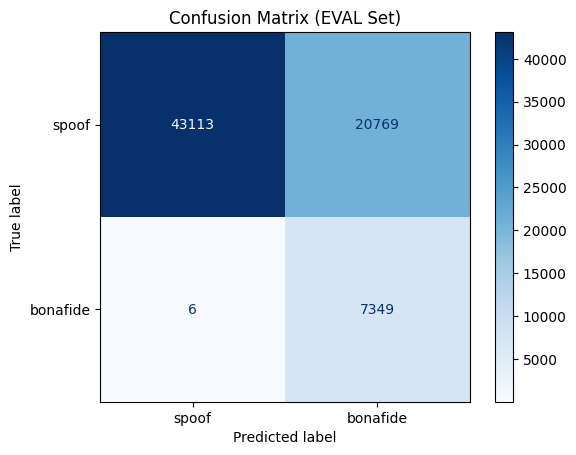


Generating ROC Curve for EVAL Set...


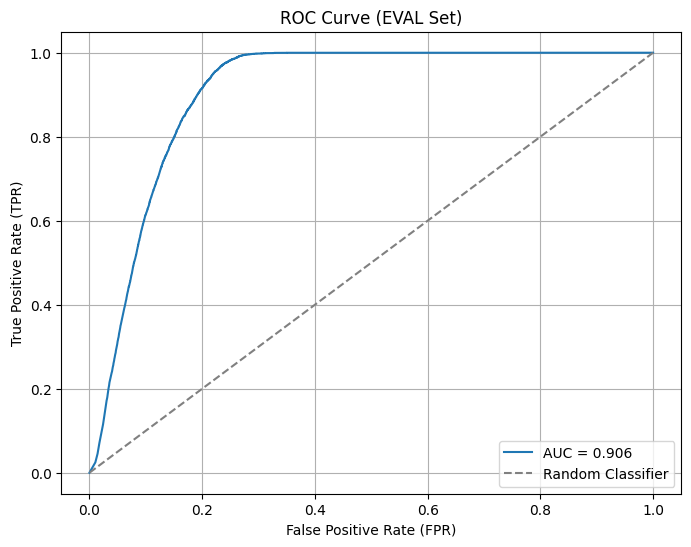


Generating Precision-Recall Curve for EVAL Set...


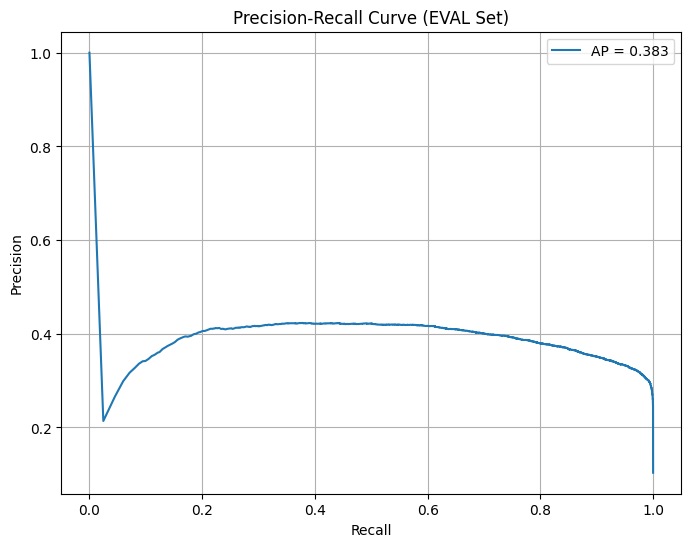


Generating Calibration Curve for EVAL Set...


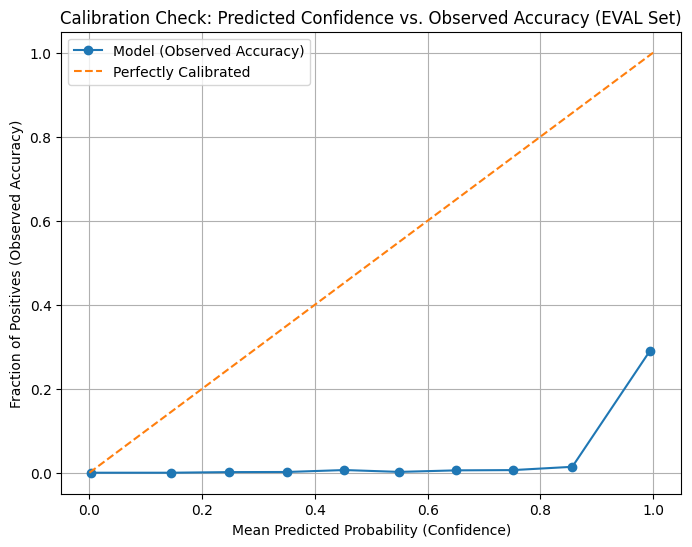

In [14]:
# Confusion matrix
print("\nGenerating Confusion Matrix for EVAL Set...")
cm_eval = confusion_matrix(y_true_eval, y_hat_eval)
ConfusionMatrixDisplay(cm_eval, display_labels=['spoof', 'bonafide']).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (EVAL Set)")
plt.show()

# ROC curve and AUC
print("\nGenerating ROC Curve for EVAL Set...")
# For ROC, use the probability of the positive class (bonafide, which is index 1)
fpr_eval, tpr_eval, _ = roc_curve(y_true_eval, y_pred_eval[:,1])
roc_auc_eval = auc(fpr_eval, tpr_eval)
plt.figure(figsize=(8, 6))
plt.plot(fpr_eval, tpr_eval, label=f"AUC = {roc_auc_eval:.3f}")
plt.plot([0,1],[0,1], linestyle='--', color='gray', label='Random Classifier')
plt.title("ROC Curve (EVAL Set)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall plot
print("\nGenerating Precision-Recall Curve for EVAL Set...")
# For PR curve, use the probability of the positive class (bonafide, which is index 1)
prec_eval, rec_eval, _ = precision_recall_curve(y_true_eval, y_pred_eval[:,1])
avg_prec_eval = average_precision_score(y_true_eval, y_pred_eval[:,1])
plt.figure(figsize=(8, 6))
plt.plot(rec_eval, prec_eval, label=f"AP = {avg_prec_eval:.3f}")
plt.title("Precision-Recall Curve (EVAL Set)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

# Calibration curve (for confidence alignment)
print("\nGenerating Calibration Curve for EVAL Set...")
# For calibration curve, use the probability of the positive class (bonafide, which is index 1)
prob_true_eval, prob_pred_eval = calibration_curve(y_true_eval, y_pred_eval[:,1], n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(prob_pred_eval, prob_true_eval, marker='o', label='Model (Observed Accuracy)')
plt.plot([0,1],[0,1], linestyle='--', label='Perfectly Calibrated')
plt.title("Calibration Check: Predicted Confidence vs. Observed Accuracy (EVAL Set)")
plt.xlabel("Mean Predicted Probability (Confidence)")
plt.ylabel("Fraction of Positives (Observed Accuracy)")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
print("\nAll tasks completed.")


All tasks completed.
